In [1]:
# File I/O
import os
import shutil

# Visualization
import cv2
from matplotlib import pyplot as plt

# Human Motion Database 51 (HMDB51) Frame Extraction

### Load train, validation, and test splits

In [2]:
def input_list_from_file(file_path):
    list = []
    with open(file_path, "r") as f:
        for item in f:
            list.append(item.strip())
    return list

In [3]:
# Input training and validation set
train_val_files = input_list_from_file(os.path.join("HMDB51", "train_val_files.txt"))
train_val_labels = input_list_from_file(os.path.join("HMDB51", "train_val_labels.txt"))

# Input test set
test_files = input_list_from_file(os.path.join("HMDB51", "test_files.txt"))
test_labels = input_list_from_file(os.path.join("HMDB51", "test_labels.txt"))

# Combine sets
all_files = train_val_files + test_files
all_labels = train_val_labels + test_labels

### Extract first, middle, and last frames from videos to save them and visualize frames from a video of each action category

In [4]:
def get_video_frame_count(file_path, fast_method=False):
    # Check that video can be loaded
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        return None

    # Fast but sometimes inaccurate frame count
    if fast_method:
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Accurate frame count
    else:
        # Loop until all video frames are processed
        frame_count = 0
        while True:
            # Read video frame
            ret, ret_frame = cap.read()
            # Video end
            if not ret:
                break
            frame_count += 1
        cap.release()

    return frame_count

In [5]:
def get_video_frames(file_path, frames, fast_method=False):
    # Check that video can be loaded
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        return None

    frames = sorted(frames)
    ret_frames = []
    # Fast but sometimes inaccurate frame retrieval
    if fast_method:
        for frame in frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
            # Read video frame
            ret, ret_frame = cap.read()
            ret_frames.append(ret_frame)        
    else:
        # Loop until all video frames are processed
        frame_count = 0
        while True:
            # Read video frame
            ret, ret_frame = cap.read()
            # Video end
            if not ret:
                break
    
            # Specified frame reached
            if frame_count in frames:
                ret_frames.append(ret_frame)
    
            frame_count += 1
    cap.release()

    return ret_frames

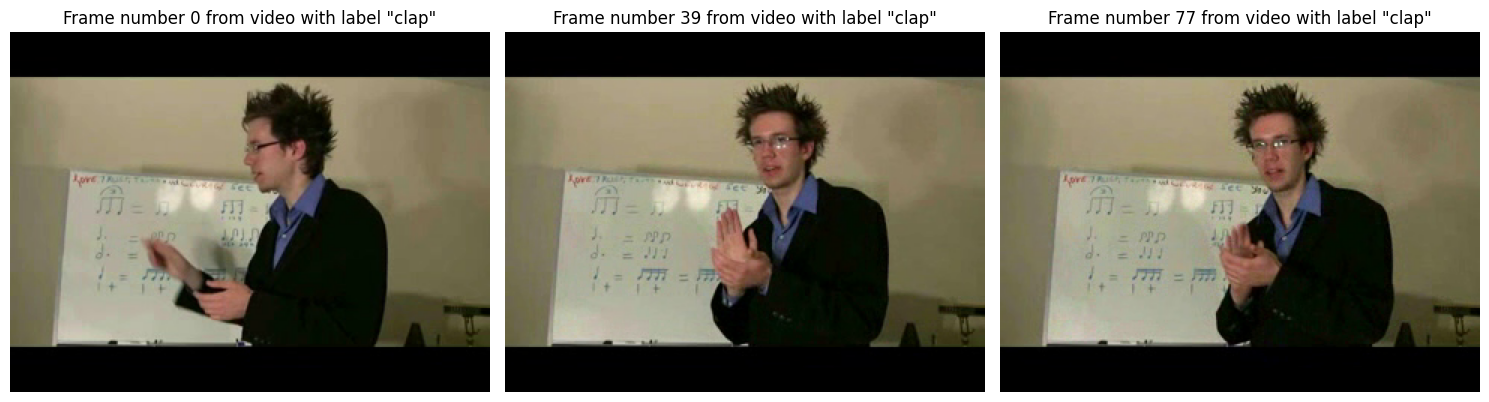

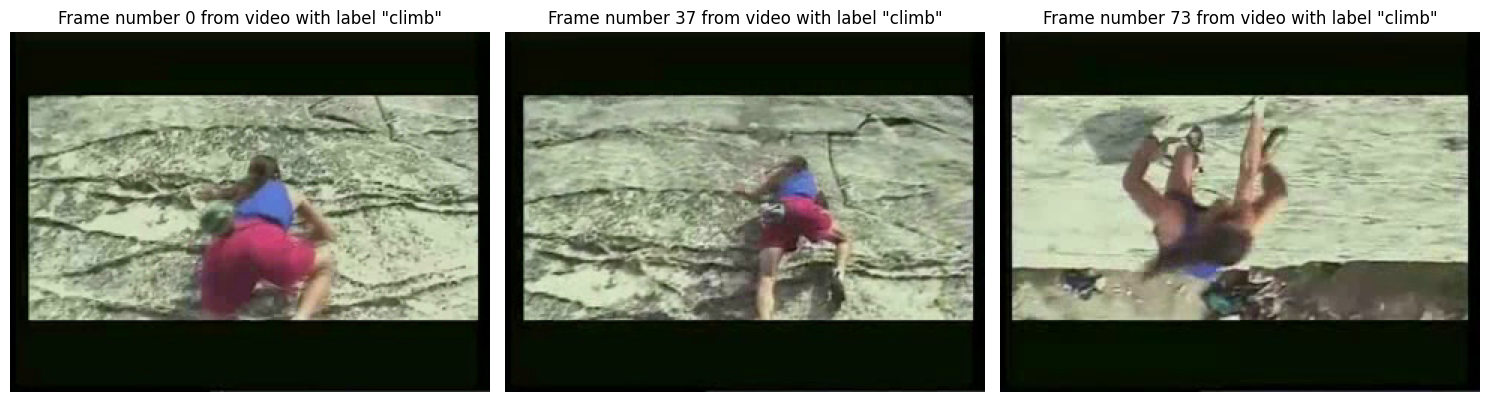

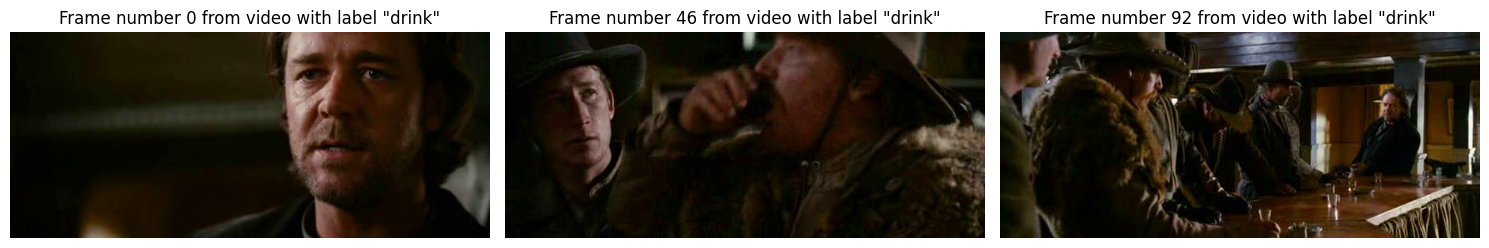

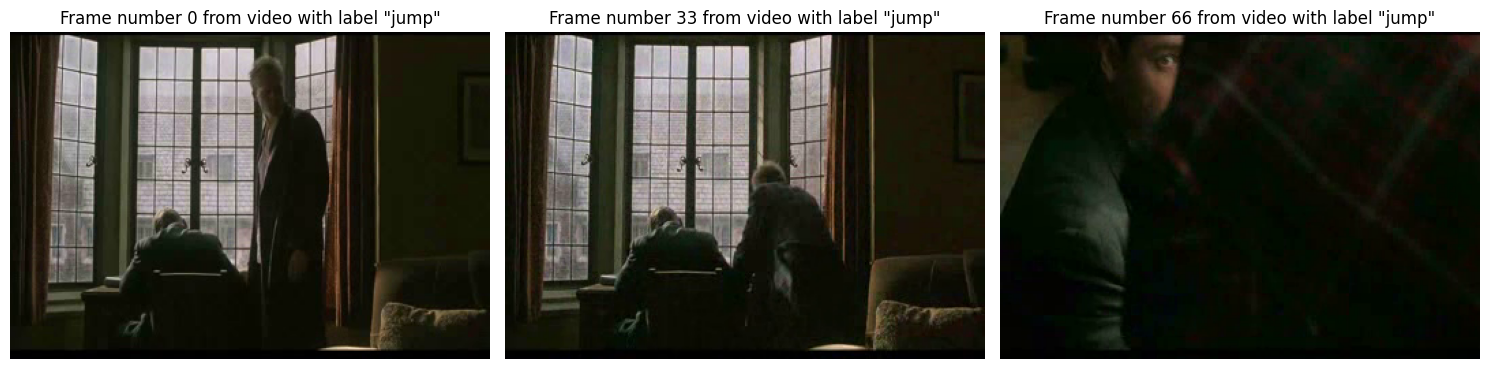

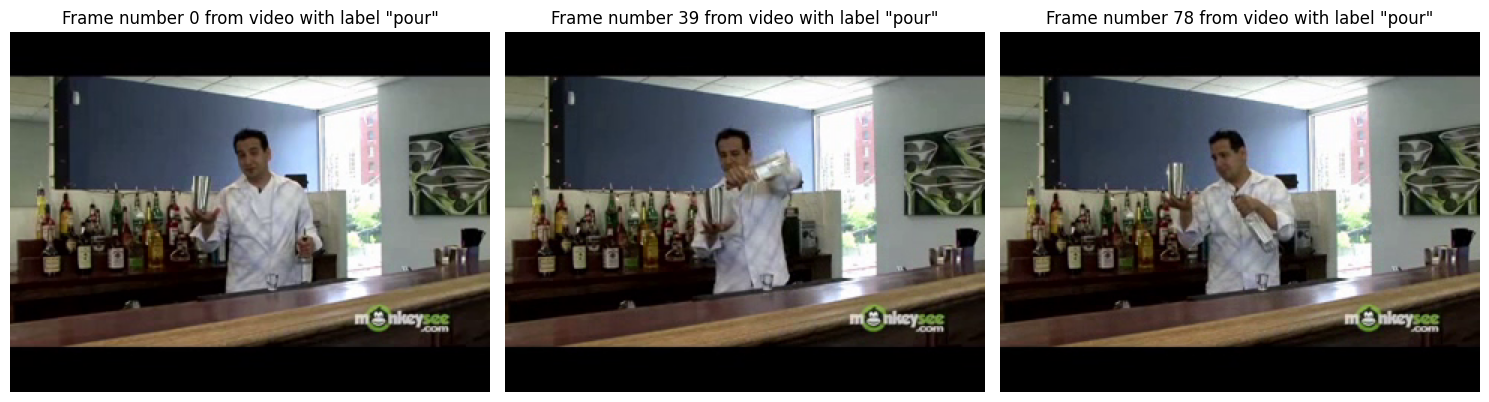

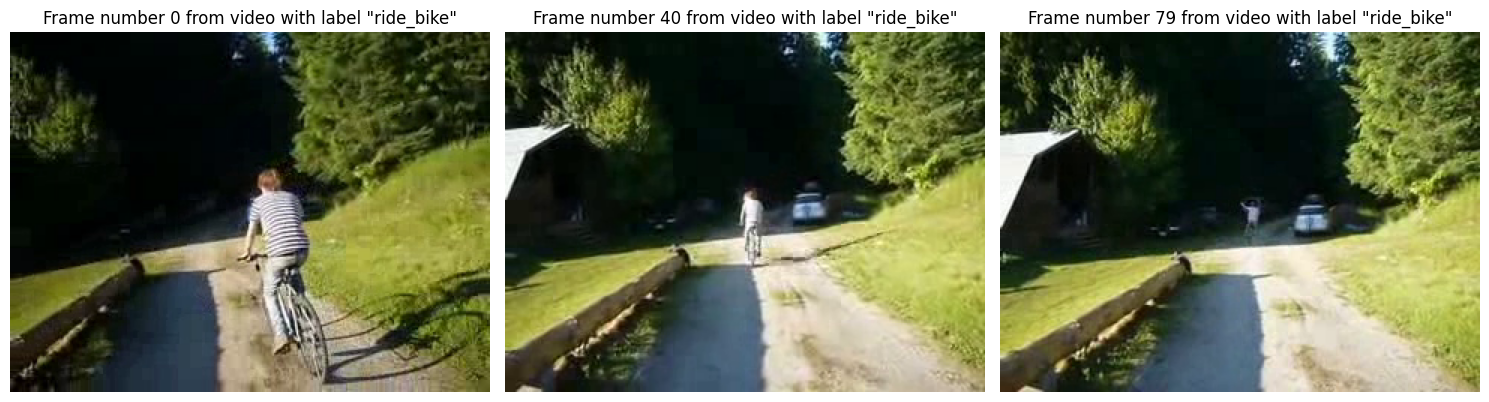

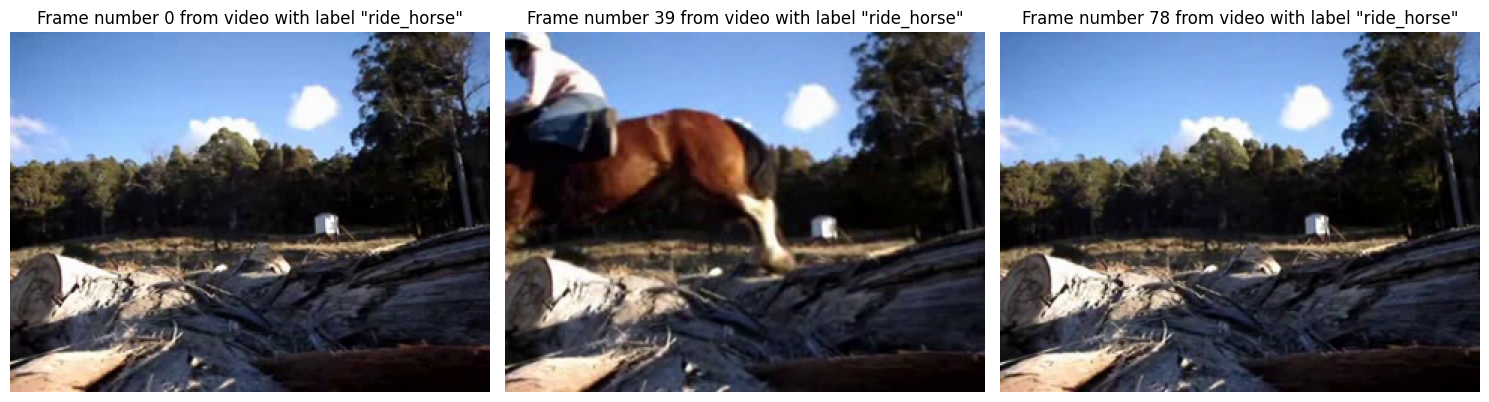

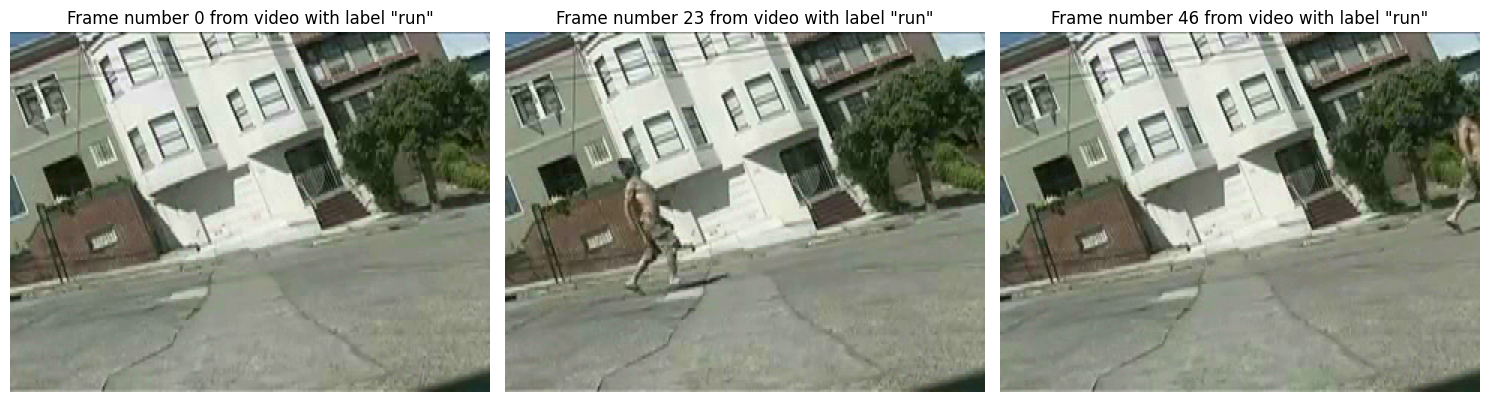

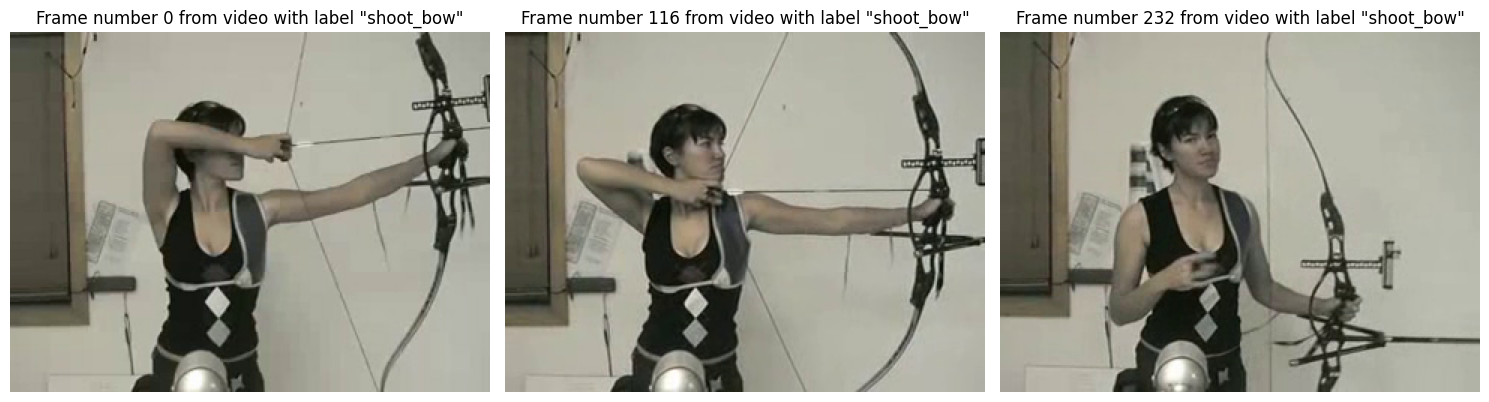

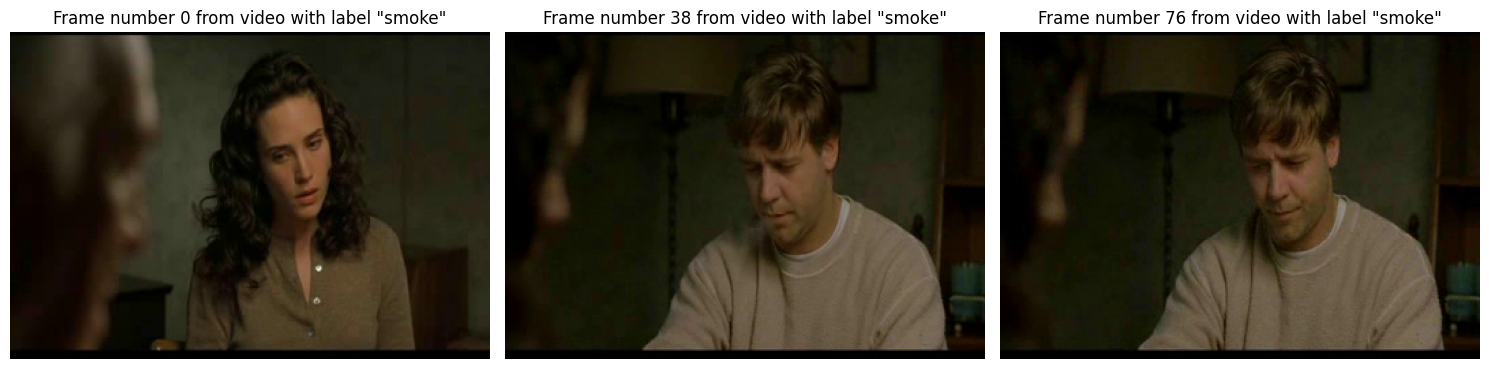

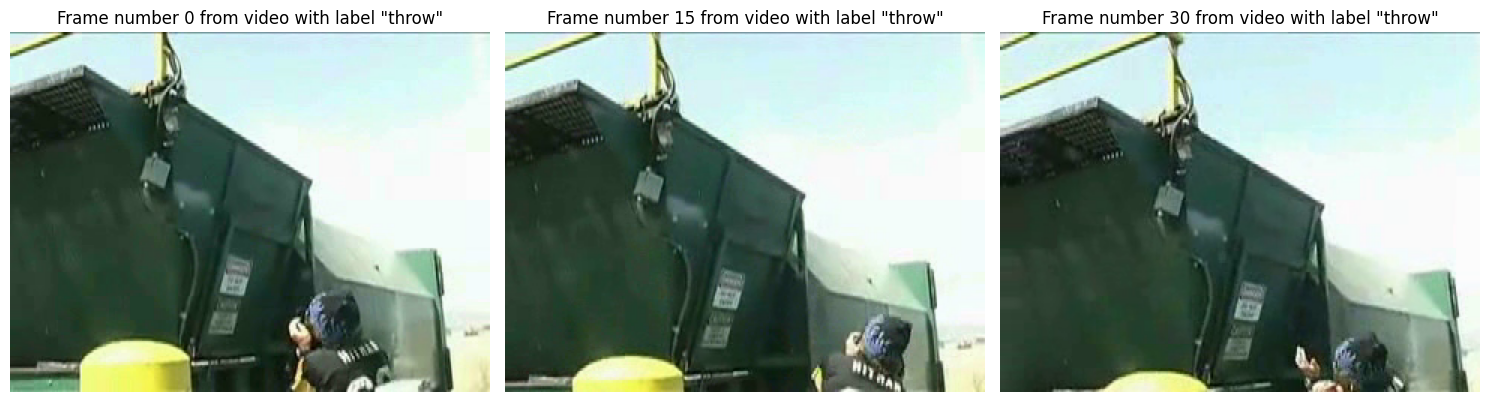

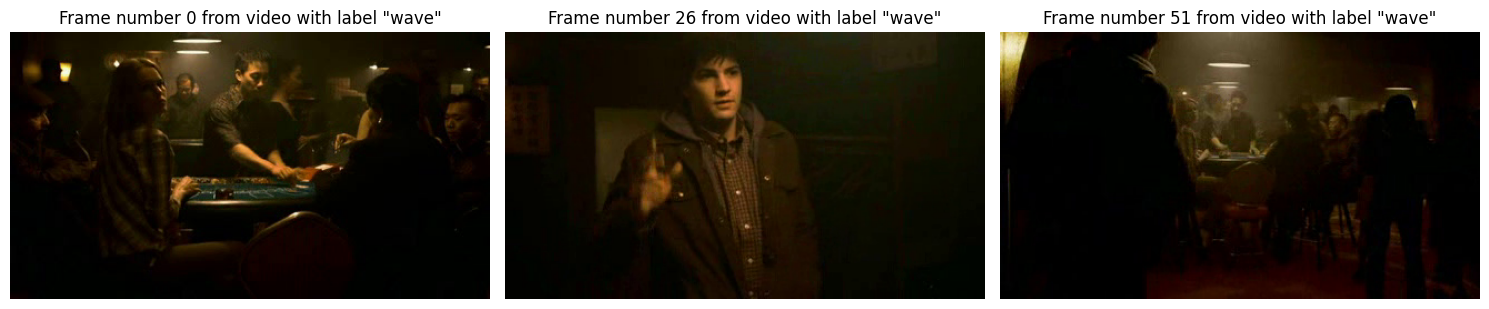

In [6]:
output_path = os.path.join("HMDB51", "frame_data")
if os.path.exists(output_path):
    shutil.rmtree(output_path)

action_categories = {"clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"}

for file, label in zip(all_files, all_labels):
    # Select first, middle, and last frame
    video_path = os.path.join("HMDB51", "video_data", label, file)
    frame_count = get_video_frame_count(video_path, fast_method=False)
    frames_idx = [0, frame_count // 2, frame_count - 1]
    frames = get_video_frames(video_path, frames_idx, fast_method=False)

    # Visualize video frames for action category
    if label in action_categories:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, (frame_idx, frame) in enumerate(zip(frames_idx, frames)):
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].set_title(f'Frame number {frame_idx} from video with label "{label}"')
            axes[i].imshow(frame_rgb)
            axes[i].axis("off")  # Hide axes
        plt.tight_layout()
        plt.show()
        action_categories.remove(label)

    # Save frames
    folder_name = os.path.join(output_path, label)
    os.makedirs(folder_name, exist_ok=True)
    file_split = file.split(".")[0]
    cv2.imwrite(os.path.join(folder_name, file_split + "_first.png"), frames[0])
    cv2.imwrite(os.path.join(folder_name, file_split + "_middle.png"), frames[1])
    cv2.imwrite(os.path.join(folder_name, file_split + "_last.png"), frames[2])